In [1]:
import sys
import os

# Add particle_detection to sys.path
sys.path.append(os.path.abspath(".."))

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from torchvision.models import ResNet18_Weights

from particle_detection.data.dataset import create_dataloaders

In [3]:
data_dir = "/home/blah-buttery/nanoparticles/images/normal"
# dataset_dir = "/Users/blah_m4/Desktop/nanoparticle/images" # macbook image location
image_size = (2048, 2048)
batch_size = 8

train_loader, test_loader = create_dataloaders(data_dir=data_dir, image_size=image_size, batch_size=batch_size)

In [4]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(f"[INFO] Using device: {device}")

[INFO] Using device: cuda


In [4]:
class CustomEncoder(nn.Module):
    def __init__(self):
        super(CustomEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),  # Grayscale input, 64 filters
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample: (H, W) -> (H/2, W/2)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 128 filters
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample: (H/2, W/2) -> (H/4, W/4)

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # 256 filters
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample: (H/4, W/4) -> (H/8, W/8)

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # 512 filters
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Downsample: (H/8, W/8) -> (H/16, W/16)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, encoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # Upsample
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),  # Output 1 channel for grayscale
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate the custom encoder and autoencoder
encoder = CustomEncoder()
autoencoder = Autoencoder(encoder)

In [6]:
# Initialize the autoencoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder(encoder).to(device)
autoencoder = nn.DataParallel(autoencoder)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for img in train_loader:
        img = img.to(device)
        
        # Forward pass
        output = autoencoder(img)
        loss = criterion(output, img)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/100], Loss: 0.0666
Epoch [2/100], Loss: 0.0533
Epoch [3/100], Loss: 0.0387
Epoch [4/100], Loss: 0.0434
Epoch [5/100], Loss: 0.1400
Epoch [6/100], Loss: 0.0407
Epoch [7/100], Loss: 0.0336
Epoch [8/100], Loss: 0.0490
Epoch [9/100], Loss: 0.0401
Epoch [10/100], Loss: 0.0454
Epoch [11/100], Loss: 0.0560
Epoch [12/100], Loss: 0.0498
Epoch [13/100], Loss: 0.0626
Epoch [14/100], Loss: 0.0458
Epoch [15/100], Loss: 0.0544
Epoch [16/100], Loss: 0.0511
Epoch [17/100], Loss: 0.0533
Epoch [18/100], Loss: 0.0480
Epoch [19/100], Loss: 0.0402
Epoch [20/100], Loss: 0.0541
Epoch [21/100], Loss: 0.0597
Epoch [22/100], Loss: 0.0394
Epoch [23/100], Loss: 0.0559
Epoch [24/100], Loss: 0.0574
Epoch [25/100], Loss: 0.0537
Epoch [26/100], Loss: 0.0455
Epoch [27/100], Loss: 0.0377
Epoch [28/100], Loss: 0.0412
Epoch [29/100], Loss: 0.0308
Epoch [30/100], Loss: 0.0230
Epoch [31/100], Loss: 0.0155
Epoch [32/100], Loss: 0.0103
Epoch [33/100], Loss: 0.0318
Epoch [34/100], Loss: 0.0148
Epoch [35/100], Loss: 0

In [7]:
# get the latent space by passing dataset through encoder
with torch.no_grad():
    sample_img = next(iter(test_loader))
    sample_img = sample_img.to(device)
    latent_space = autoencoder.module.encoder(sample_img)
    print(f"Shape of latent space: {latent_space.shape}")

Shape of latent space: torch.Size([3, 512, 128, 128])


In [8]:
latent_space_reshaped = latent_space.permute(0, 2, 3, 1).reshape(-1, latent_space.shape[1])  # Shape: [N, C]
print(f"Shape of reshaped latent space: {latent_space_reshaped.shape}")

Shape of reshaped latent space: torch.Size([49152, 512])


In [10]:
from sklearn.mixture import GaussianMixture

# apply initial gmm clustering
gmm = GaussianMixture(n_components=5, random_state=42, covariance_type="full")
gmm.fit(latent_space_reshaped.cpu().numpy())
cluster_labels = gmm.predict(latent_space_reshaped.cpu().numpy())

In [11]:
# Map Cluster Labels Back to Spatial Grid
grid_cols = latent_space.shape[3]  # 1024 / 8 = 128
grid_rows = latent_space.shape[2]  # 1024 / 8 = 128
cluster_labels_grid = cluster_labels.reshape(latent_space.shape[0], grid_rows, grid_cols)  # Shape: [B, H, W]

print(f"Cluster labels grid shape: {cluster_labels_grid.shape}")

Cluster labels grid shape: (3, 128, 128)


In [14]:
def visualize_clusters_on_image(image_batch, cluster_labels_grid):
    """
    Visualize clusters directly on the spatial grid of the image.
    
    Args:
        image_batch (torch.Tensor): Batch of images, shape [B, C, H, W].
        cluster_labels_grid (np.ndarray): Cluster labels, shape [B, H, W].
    
    Returns:
        None
    """
    # Select the first image and its cluster labels
    single_image = image_batch[0]  # Shape: [C, H, W]
    single_cluster_labels = cluster_labels_grid[0]  # Shape: [H, W]

    # Visualize the image and clusters
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 2, 1)
    image_np = single_image.cpu().numpy().transpose(1, 2, 0)  # Convert CHW to HWC
    if image_np.max() > 1.0:
        image_np = image_np / 255.0  # Normalize
    plt.imshow(image_np, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    # Cluster Overlay
    plt.subplot(1, 2, 2)
    plt.imshow(single_cluster_labels, cmap="viridis")
    plt.title("Cluster Visualization")
    plt.colorbar(label="Cluster")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

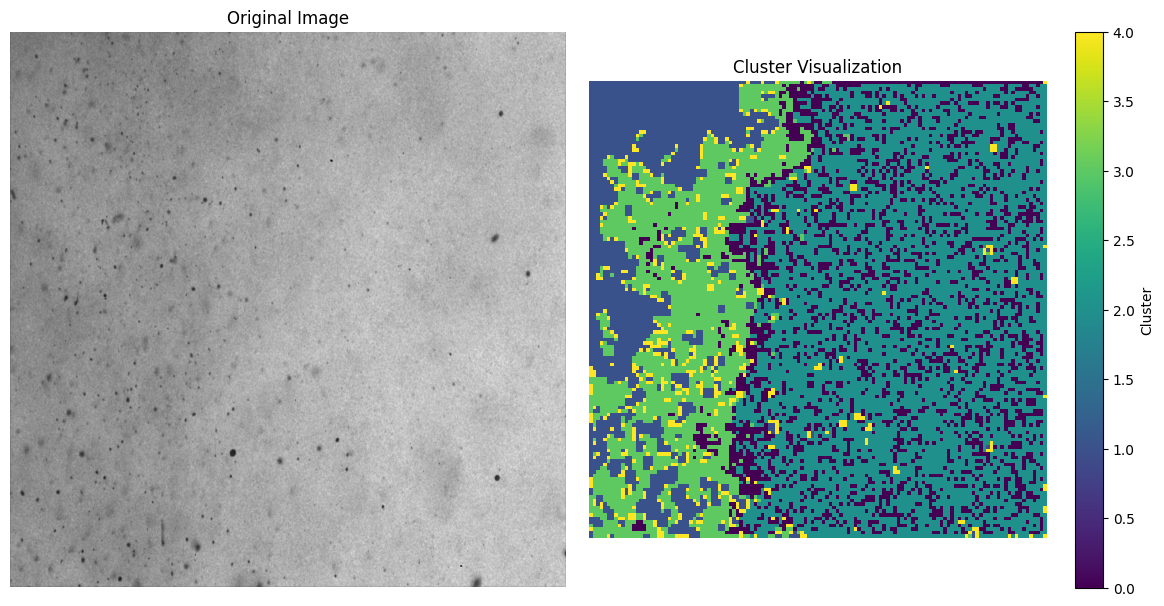

In [15]:
visualize_clusters_on_image(sample_img, cluster_labels_grid)

In [16]:
# okay, but can we improve the results?
# we can do this if we elimante some of the least important channels of the latent space
from sklearn.decomposition import PCA

# Convert PyTorch tensor to NumPy array
latent_space_np = latent_space_reshaped.cpu().numpy()  # Shape: [8192, 512]

# Apply PCA
n_components = 50  # Adjust based on your needs (e.g., explained variance)
pca = PCA(n_components=n_components)
latent_space_pca = pca.fit_transform(latent_space_np)  # Shape: [8192, 50]

print(f"Shape after PCA: {latent_space_pca.shape}")

Shape after PCA: (49152, 50)


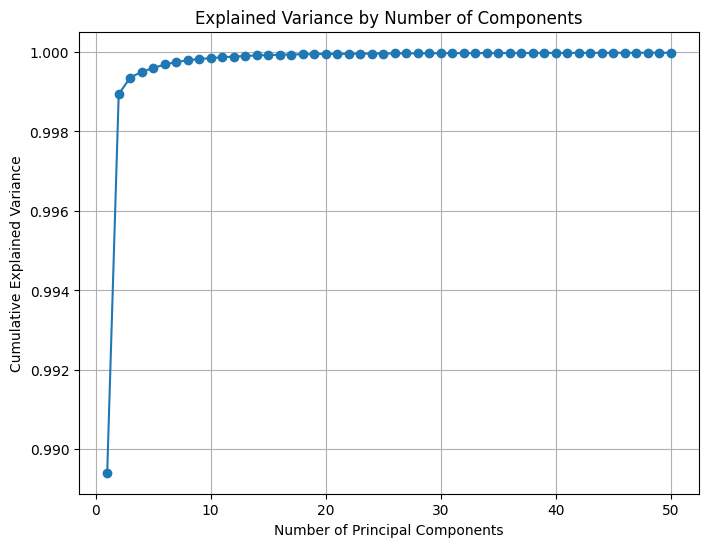

In [17]:
# Plot the explained variance
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by Number of Components")
plt.grid()
plt.show()

In [18]:
pca = PCA(n_components=5)
latent_space_pca = pca.fit_transform(latent_space_np)  # Shape: [8192, 20]
print(f"Shape after PCA: {latent_space_pca.shape}")

Shape after PCA: (49152, 5)


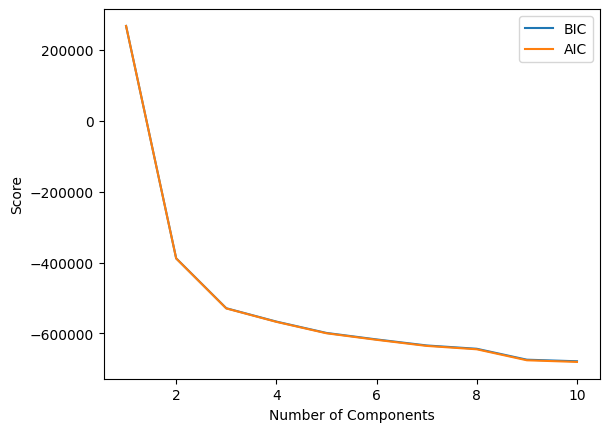

In [19]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

n_components_range = range(1, 11)
bic = []
aic = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(latent_space_pca)  # Replace 'data' with your dataset
    bic.append(gmm.bic(latent_space_pca))
    aic.append(gmm.aic(latent_space_pca))

plt.plot(n_components_range, bic, label="BIC")
plt.plot(n_components_range, aic, label="AIC")
plt.xlabel("Number of Components")
plt.ylabel("Score")
plt.legend()
plt.show()


In [20]:
gmm = GaussianMixture(n_components=3, random_state=42, covariance_type="full")
gmm.fit(latent_space_pca)  # Fit on reshaped latent space
cluster_labels = gmm.predict(latent_space_pca)  # Shape: [N]

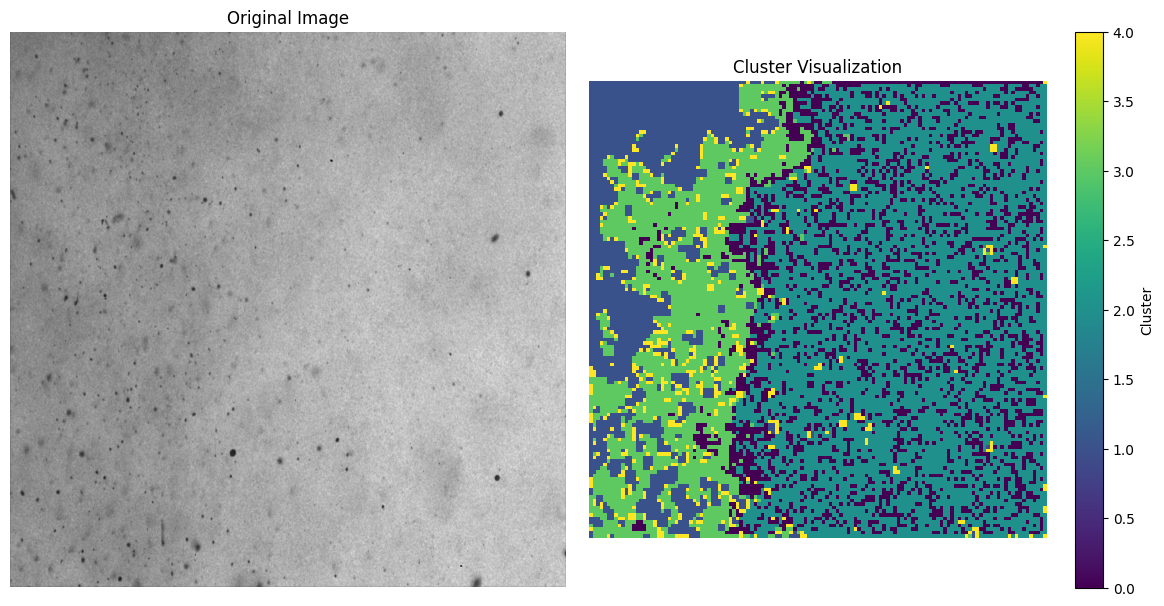

In [21]:
visualize_clusters_on_image(sample_img, cluster_labels_grid)

Unique cluster labels: [0 1 2 3 4]


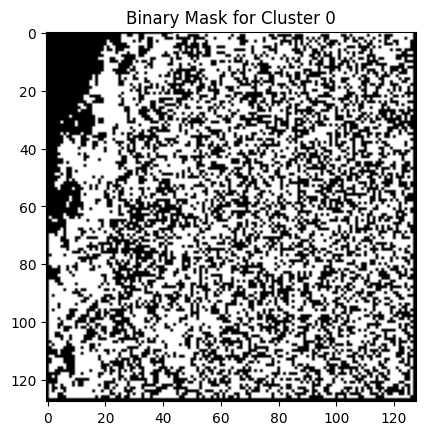

Cluster 0: Found 17 contours.


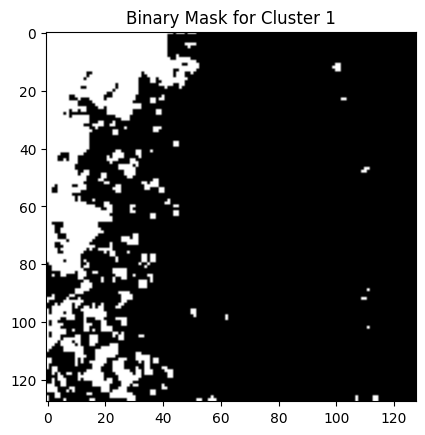

Cluster 1: Found 72 contours.


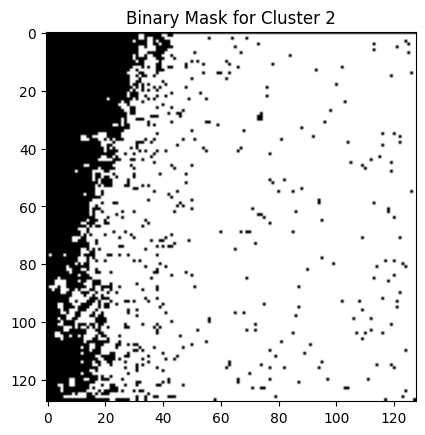

Cluster 2: Found 30 contours.


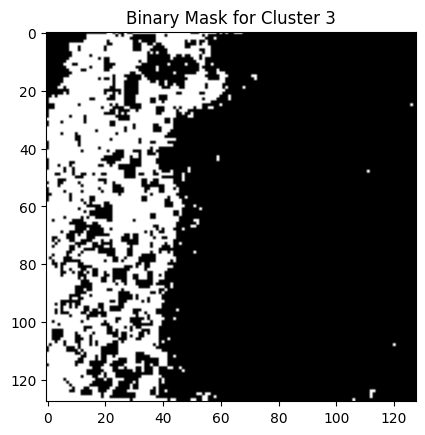

Cluster 3: Found 39 contours.


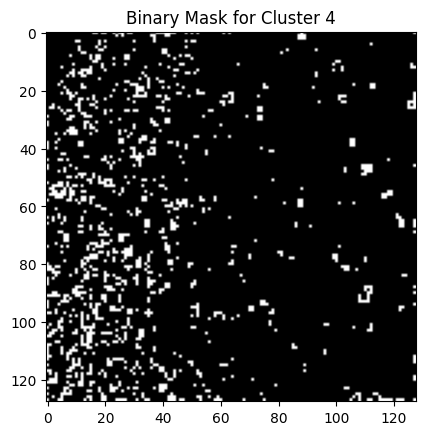

Cluster 4: Found 428 contours.


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

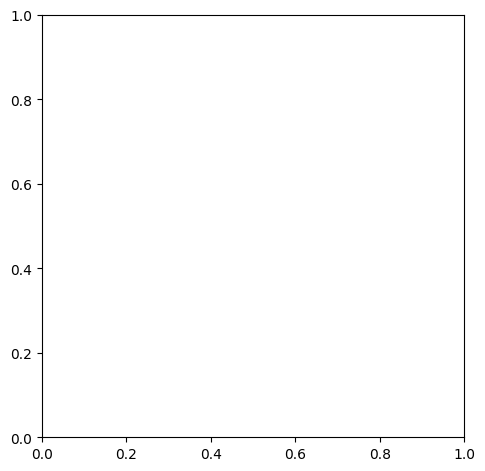

In [22]:
# Debug: Check cluster labels
print(f"Unique cluster labels: {np.unique(cluster_labels_grid)}")

image_np = sample_img[0].cpu().numpy().transpose(1, 2, 0)
visualized_img = image_np.copy()  # Create a copy for visualization

# Iterate over unique clusters
for cluster in np.unique(cluster_labels_grid):
    # Create a binary mask for the current cluster
    cluster_mask = (cluster_labels_grid == cluster).astype(np.uint8)
    
    if cluster_mask.ndim == 3:
        cluster_mask = np.sum(cluster_mask, axis=0)
    cluster_mask = (cluster_mask > 0).astype(np.uint8)
    
    # Debug: Visualize the binary mask
    plt.imshow(cluster_mask, cmap='gray')
    plt.title(f"Binary Mask for Cluster {cluster}")
    plt.show()

    # Find contours
    contours, _ = cv2.findContours(cluster_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Cluster {cluster}: Found {len(contours)} contours.")

    # Draw the contours on the visualization image
    cv2.drawContours(visualized_img, contours, -1, (255, 0, 0), 2)

# Visualize results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(sample_img, cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(visualized_img, cmap='gray')
plt.title("Particles Visualized")
plt.axis("off")

plt.tight_layout()
plt.show()

In [57]:
def visualize_single_cluster(sample_img, cluster_labels_grid, cluster_to_visualize, scale_factor=16):
    """
    Visualizes a single cluster on the image.

    Args:
        sample_img (torch.Tensor): The image tensor of shape [1, C, H, W].
        cluster_labels_grid (np.ndarray): The cluster labels grid of shape [B, H, W].
        cluster_to_visualize (int): The specific cluster to visualize.
        scale_factor (int): Scaling factor to map latent space coordinates to original image coordinates.
    
    Returns:
        None: Displays the image with the selected cluster highlighted.
    """
    print(f"Processing cluster: {cluster_to_visualize}")
    
    # Convert `sample_img` to NumPy for visualization
    image_np = sample_img[0].cpu().numpy().transpose(1, 2, 0)  # Convert CHW to HWC
    image_with_cluster = image_np.copy()
    
    # Extract all coordinates for the specified cluster
    coords = np.argwhere(cluster_labels_grid[0] == cluster_to_visualize)  # Get coordinates (row, col)
    print(f"Cluster {cluster_to_visualize}: {len(coords)} points found.")
    
    # Map the coordinates to the original image dimensions
    for coord in coords:
        y, x = coord * scale_factor  # Scale to original dimensions
        # Draw a small rectangle (just around the coordinate)
        cv2.rectangle(
            image_with_cluster,
            (x, y),
            (x + 1, y + 1),  # A box of size 1x1 pixel
            (255, 0, 0),  # Red color in BGR
            thickness=1  # Thickness of the rectangle
        )
    
    # Visualize the Image with Highlighted Cluster
    plt.figure(figsize=(12, 12))
    plt.imshow(image_with_cluster, cmap="gray")
    plt.title(f"Cluster {cluster_to_visualize} Highlighted")
    plt.axis("off")
    plt.show()

In [23]:
def visualize_single_cluster(sample_img, cluster_labels_grid, cluster_to_visualize, scale_factor=16):
    """
    Visualizes a single cluster on a grayscale image.

    Args:
        sample_img (torch.Tensor): The grayscale image tensor of shape [1, 1, H, W].
        cluster_labels_grid (np.ndarray): The cluster labels grid of shape [B, H, W].
        cluster_to_visualize (int): The specific cluster to visualize.
        scale_factor (int): Scaling factor to map latent space coordinates to original image coordinates.
    
    Returns:
        None: Displays the image with the selected cluster highlighted.
    """
    print(f"Processing cluster: {cluster_to_visualize}")
    
    # Convert `sample_img` to NumPy for visualization
    image_np = sample_img[0, 0].cpu().numpy()  # Convert to 2D array (H, W)
    image_with_cluster = np.stack([image_np] * 3, axis=-1)  # Convert grayscale to RGB for visualization
    
    # Extract all coordinates for the specified cluster
    coords = np.argwhere(cluster_labels_grid[0] == cluster_to_visualize)  # Get coordinates (row, col)
    print(f"Cluster {cluster_to_visualize}: {len(coords)} points found.")
    
    # Map the coordinates to the original image dimensions
    for coord in coords:
        y, x = coord * scale_factor  # Scale to original dimensions
        # Draw a small rectangle (just around the coordinate)
        cv2.rectangle(
            image_with_cluster,
            (x, y),
            (x + 1, y + 1),  # A box of size 1x1 pixel
            (255, 0, 0),  # Red color in BGR (converted to RGB)
            thickness=1  # Thickness of the rectangle
        )
    
    # Visualize the Image with Highlighted Cluster
    plt.figure(figsize=(12, 12))
    plt.imshow(image_with_cluster, cmap="gray")
    plt.title(f"Cluster {cluster_to_visualize} Highlighted")
    plt.axis("off")
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Processing cluster: 4
Cluster 4: 628 points found.


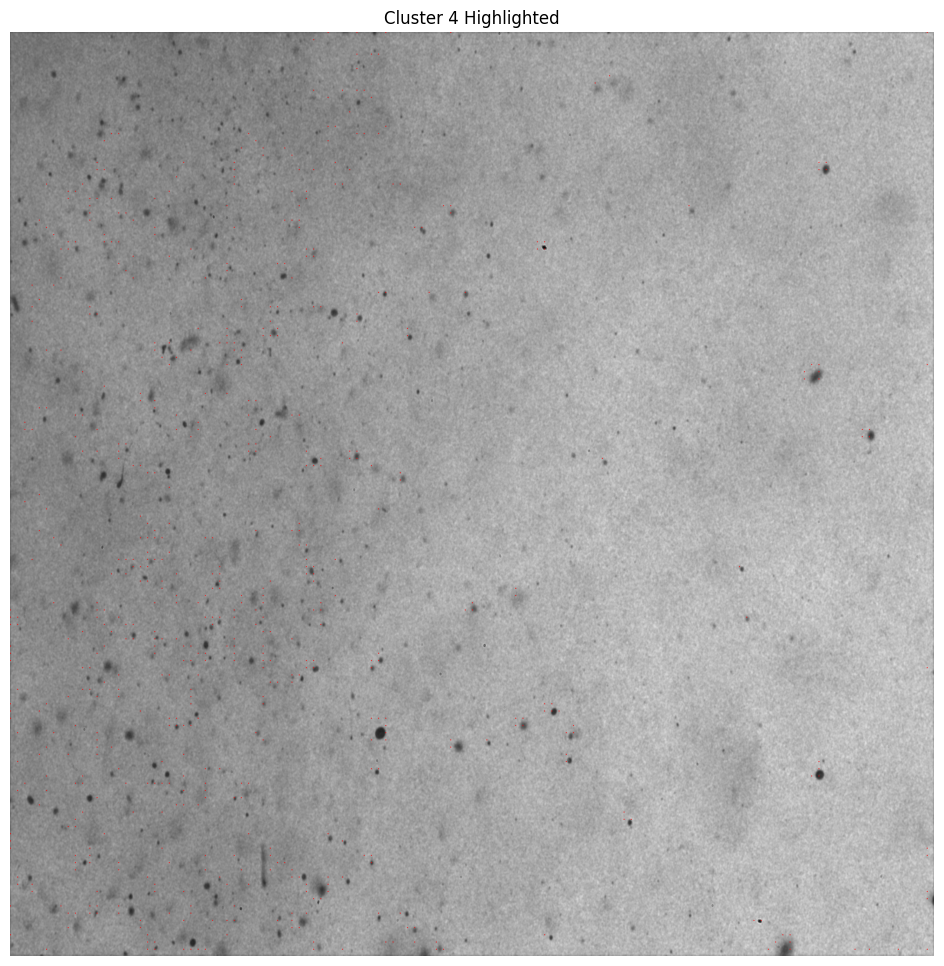

In [24]:
cluster_to_visualize = 4  # Specify the cluster you want to visualize
visualize_single_cluster(sample_img, cluster_labels_grid, cluster_to_visualize, scale_factor=16)

In [25]:
def visualize_clusters_with_contours(sample_img, cluster_labels_grid, scale_factor=16):
    """
    Visualize clusters with contours overlaid on the original image.
    
    Args:
        sample_img (torch.Tensor): Grayscale image tensor, shape [1, 1, H, W].
        cluster_labels_grid (np.ndarray): Cluster labels grid, shape [B, H, W].
        scale_factor (int): Scaling factor to map latent space to original dimensions.
    
    Returns:
        None: Displays the image with contours for each cluster.
    """
    # Convert image to NumPy
    image_np = sample_img[0, 0].cpu().numpy()  # Shape: [H, W]
    image_resized = cv2.resize(image_np, (image_np.shape[1] * scale_factor, image_np.shape[0] * scale_factor))
    image_colored = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2BGR)  # Convert to RGB

    # Upscale cluster labels to match original image size
    cluster_labels_resized = cv2.resize(
        cluster_labels_grid[0],
        (image_resized.shape[1], image_resized.shape[0]),
        interpolation=cv2.INTER_NEAREST
    )

    # Loop through unique clusters
    unique_clusters = np.unique(cluster_labels_resized)
    for cluster_id in unique_clusters:
        # Create a binary mask for the current cluster
        mask = (cluster_labels_resized == cluster_id).astype(np.uint8)

        # Find contours for the cluster
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw contours on the image
        cv2.drawContours(image_colored, contours, -1, (0, 255, 0), thickness=2)  # Green for contours

    # Visualize the result
    plt.figure(figsize=(12, 12))
    plt.imshow(image_colored)
    plt.title("Clusters with Contours")
    plt.axis("off")
    plt.show()

In [27]:
def visualize_clusters_with_contours(sample_img, cluster_labels_grid, scale_factor=16):
    """
    Visualize clusters with contours overlaid on the original image.

    Args:
        sample_img (torch.Tensor): Grayscale image tensor, shape [1, 1, H, W].
        cluster_labels_grid (np.ndarray): Cluster labels grid, shape [B, H, W].
        scale_factor (int): Scaling factor to map latent space to original dimensions.

    Returns:
        None: Displays the image with contours for each cluster.
    """
    # Convert the image to NumPy
    image_np = sample_img[0, 0].cpu().numpy()  # Shape: [H, W]
    original_h, original_w = image_np.shape

    # Upscale the image to match the original size
    image_resized = cv2.resize(
        image_np, (original_w, original_h), interpolation=cv2.INTER_LINEAR
    )
    image_colored = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2BGR)  # Convert to RGB

    # Upscale the cluster labels to match the original image size
    cluster_labels_resized = cv2.resize(
        cluster_labels_grid[0],  # Use the first image in the batch
        (original_w, original_h),
        interpolation=cv2.INTER_NEAREST,
    )

    # Debugging: Verify the dimensions of the resized cluster labels
    print(f"Original image size: {original_h}x{original_w}")
    print(f"Resized cluster labels size: {cluster_labels_resized.shape}")

    # Loop through each unique cluster and draw its contours
    unique_clusters = np.unique(cluster_labels_resized)
    print(f"Unique clusters found: {unique_clusters}")

    for cluster_id in unique_clusters:
        # Create a binary mask for the current cluster
        mask = (cluster_labels_resized == cluster_id).astype(np.uint8)

        # Find contours for the current cluster
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw contours on the image
        color = tuple(np.random.randint(0, 255, size=3).tolist())  # Random color
        cv2.drawContours(image_colored, contours, -1, color, thickness=2)

    # Visualize the final result
    plt.figure(figsize=(12, 12))
    plt.imshow(image_colored)
    plt.title("Clusters with Contours")
    plt.axis("off")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.023529412..225.0].


Original image size: 2048x2048
Resized cluster labels size: (2048, 2048)
Unique clusters found: [0 1 2 3 4]


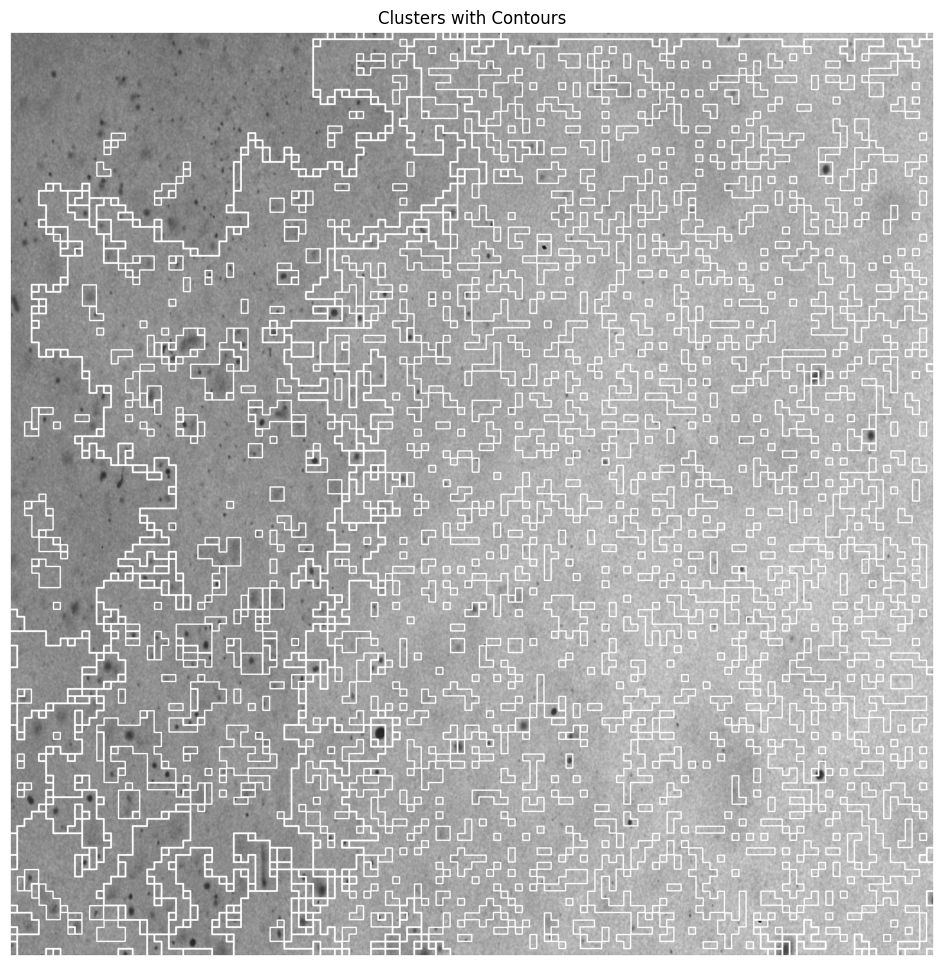

In [28]:
visualize_clusters_with_contours(sample_img, cluster_labels_grid, scale_factor=16)

In [30]:
def visualize_single_cluster_contour(sample_img, cluster_labels_grid, cluster_id_to_display, scale_factor=16):
    """
    Visualize a single cluster with contours overlaid on the original image.

    Args:
        sample_img (torch.Tensor): Grayscale image tensor, shape [1, 1, H, W].
        cluster_labels_grid (np.ndarray): Cluster labels grid, shape [B, H, W].
        cluster_id_to_display (int): The specific cluster label to isolate and display.
        scale_factor (int): Scaling factor to map latent space to original dimensions.

    Returns:
        None: Displays the image with contours for the specified cluster.
    """
    # Convert the image to NumPy
    image_np = sample_img[0, 0].cpu().numpy()  # Shape: [H, W]
    original_h, original_w = image_np.shape

    # Upscale the image to match the original size
    image_resized = cv2.resize(
        image_np, (original_w, original_h), interpolation=cv2.INTER_LINEAR
    )
    image_colored = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2BGR)  # Convert to RGB

    # Upscale the cluster labels to match the original image size
    cluster_labels_resized = cv2.resize(
        cluster_labels_grid[0],  # Use the first image in the batch
        (original_w, original_h),
        interpolation=cv2.INTER_NEAREST,
    )

    # Create a binary mask for the specified cluster
    mask = (cluster_labels_resized == cluster_id_to_display).astype(np.uint8)

    # Debugging: Verify the mask
    print(f"Displaying cluster ID: {cluster_id_to_display}")
    print(f"Number of pixels in cluster: {np.sum(mask)}")

    # Find contours for the specified cluster
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours for the cluster
    cv2.drawContours(image_colored, contours, -1, (0, 255, 0), thickness=2)  # Green for contours

    # Visualize the final result
    plt.figure(figsize=(12, 12))
    plt.imshow(image_colored)
    plt.title(f"Cluster {cluster_id_to_display} with Contours")
    plt.axis("off")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Displaying cluster ID: 1
Number of pixels in cluster: 627712


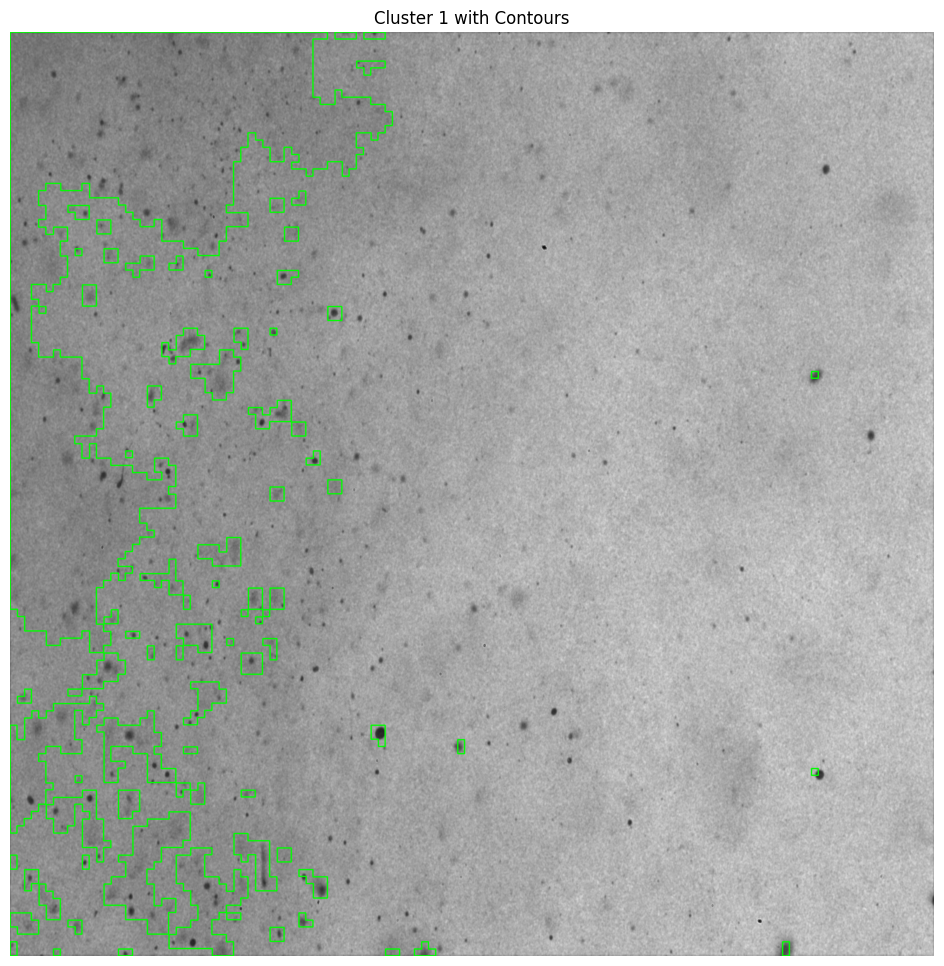

In [36]:
cluster_id = 1

# Call the function
visualize_single_cluster_contour(sample_img, cluster_labels_grid, cluster_id_to_display=cluster_id, scale_factor=16)

In [37]:
def filter_particles_by_size_and_shape(sample_img, cluster_labels_grid, cluster_id_to_display, min_area=10, max_area=500, min_circularity=0.7):
    """
    Filter particles based on size and shape and overlay contours on the image.

    Args:
        sample_img (torch.Tensor): Grayscale image tensor, shape [1, 1, H, W].
        cluster_labels_grid (np.ndarray): Cluster labels grid, shape [B, H, W].
        cluster_id_to_display (int): The specific cluster label to isolate and filter.
        min_area (int): Minimum area of a valid particle.
        max_area (int): Maximum area of a valid particle.
        min_circularity (float): Minimum circularity of a valid particle (0 to 1).
    
    Returns:
        None: Displays the filtered particles overlaid on the image.
    """
    # Convert the image to NumPy
    image_np = sample_img[0, 0].cpu().numpy()  # Shape: [H, W]
    original_h, original_w = image_np.shape

    # Upscale the image to match the original size
    image_resized = cv2.resize(
        image_np, (original_w, original_h), interpolation=cv2.INTER_LINEAR
    )
    image_colored = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2BGR)  # Convert to RGB

    # Upscale the cluster labels to match the original image size
    cluster_labels_resized = cv2.resize(
        cluster_labels_grid[0],
        (original_w, original_h),
        interpolation=cv2.INTER_NEAREST,
    )

    # Create a binary mask for the specified cluster
    mask = (cluster_labels_resized == cluster_id_to_display).astype(np.uint8)

    # Find contours for the specified cluster
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours by size and shape
    valid_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if min_area <= area <= max_area:
            # Calculate circularity
            perimeter = cv2.arcLength(contour, True)
            if perimeter == 0:
                continue
            circularity = 4 * np.pi * (area / (perimeter ** 2))
            if circularity >= min_circularity:
                valid_contours.append(contour)

    # Debugging: Print the number of valid contours
    print(f"Total contours found: {len(contours)}")
    print(f"Valid particles after filtering: {len(valid_contours)}")

    # Draw valid contours
    cv2.drawContours(image_colored, valid_contours, -1, (0, 255, 0), thickness=2)  # Green for valid contours

    # Visualize the final result
    plt.figure(figsize=(12, 12))
    plt.imshow(image_colored)
    plt.title(f"Filtered Particles from Cluster {cluster_id_to_display}")
    plt.axis("off")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Total contours found: 288
Valid particles after filtering: 238


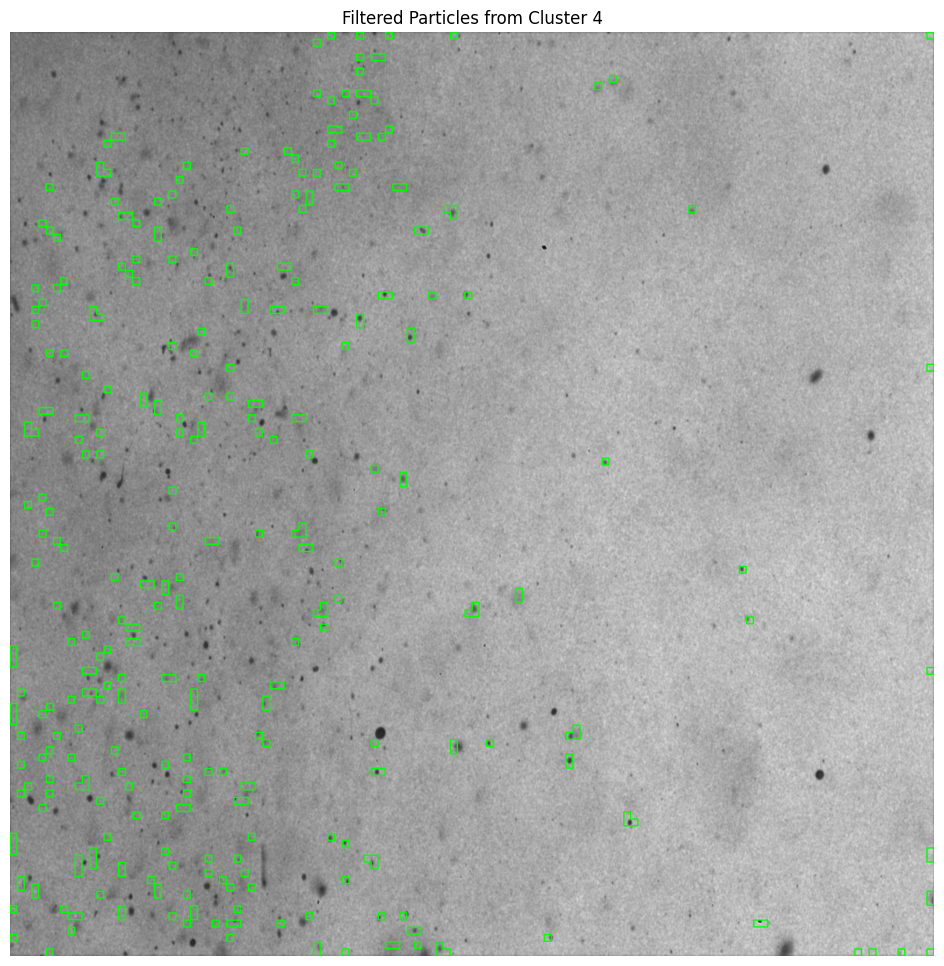

In [46]:
filter_particles_by_size_and_shape(
    sample_img=sample_img,
    cluster_labels_grid=cluster_labels_grid,
    cluster_id_to_display=4,  # Replace with the cluster ID to filter
    min_area=0.1,              # Minimum particle size
    max_area=900,             # Maximum particle size
    min_circularity=0.2       # Minimum circularity (close to 1 for near-circles)
)

In [47]:
def display_all_clusters_and_filter_by_size(
    sample_img, cluster_labels_grid, min_area=10, max_area=500
):
    """
    Display all clusters and then apply size-based filtering to isolate particles.

    Args:
        sample_img (torch.Tensor): Grayscale image tensor, shape [1, 1, H, W].
        cluster_labels_grid (np.ndarray): Cluster labels grid, shape [B, H, W].
        min_area (int): Minimum area of a valid particle.
        max_area (int): Maximum area of a valid particle.

    Returns:
        None: Displays the image with all clusters and filtered particles.
    """
    # Convert the image to NumPy
    image_np = sample_img[0, 0].cpu().numpy()  # Shape: [H, W]
    original_h, original_w = image_np.shape

    # Upscale the image to match the original size
    image_resized = cv2.resize(
        image_np, (original_w, original_h), interpolation=cv2.INTER_LINEAR
    )
    image_colored = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2BGR)  # Convert to RGB

    # Upscale the cluster labels to match the original image size
    cluster_labels_resized = cv2.resize(
        cluster_labels_grid[0],
        (original_w, original_h),
        interpolation=cv2.INTER_NEAREST,
    )

    # Create a binary mask for all clusters
    unique_clusters = np.unique(cluster_labels_resized)
    all_contours = []
    for cluster_id in unique_clusters:
        mask = (cluster_labels_resized == cluster_id).astype(np.uint8)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        all_contours.extend(contours)

    # Visualize all clusters
    image_all_clusters = image_colored.copy()
    cv2.drawContours(image_all_clusters, all_contours, -1, (0, 255, 0), thickness=1)  # Green for all contours
    plt.figure(figsize=(12, 12))
    plt.imshow(image_all_clusters)
    plt.title("All Clusters with Contours")
    plt.axis("off")
    plt.show()

    # Apply size filtering
    valid_contours = [
        contour
        for contour in all_contours
        if min_area <= cv2.contourArea(contour) <= max_area
    ]

    # Visualize filtered contours
    image_filtered = image_colored.copy()
    cv2.drawContours(image_filtered, valid_contours, -1, (255, 0, 0), thickness=2)  # Blue for valid contours
    plt.figure(figsize=(12, 12))
    plt.imshow(image_filtered)
    plt.title(f"Filtered Particles (Area: {min_area}-{max_area})")
    plt.axis("off")
    plt.show()

    # Debugging: Print total contours and filtered contours
    print(f"Total contours found: {len(all_contours)}")
    print(f"Valid contours after filtering: {len(valid_contours)}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


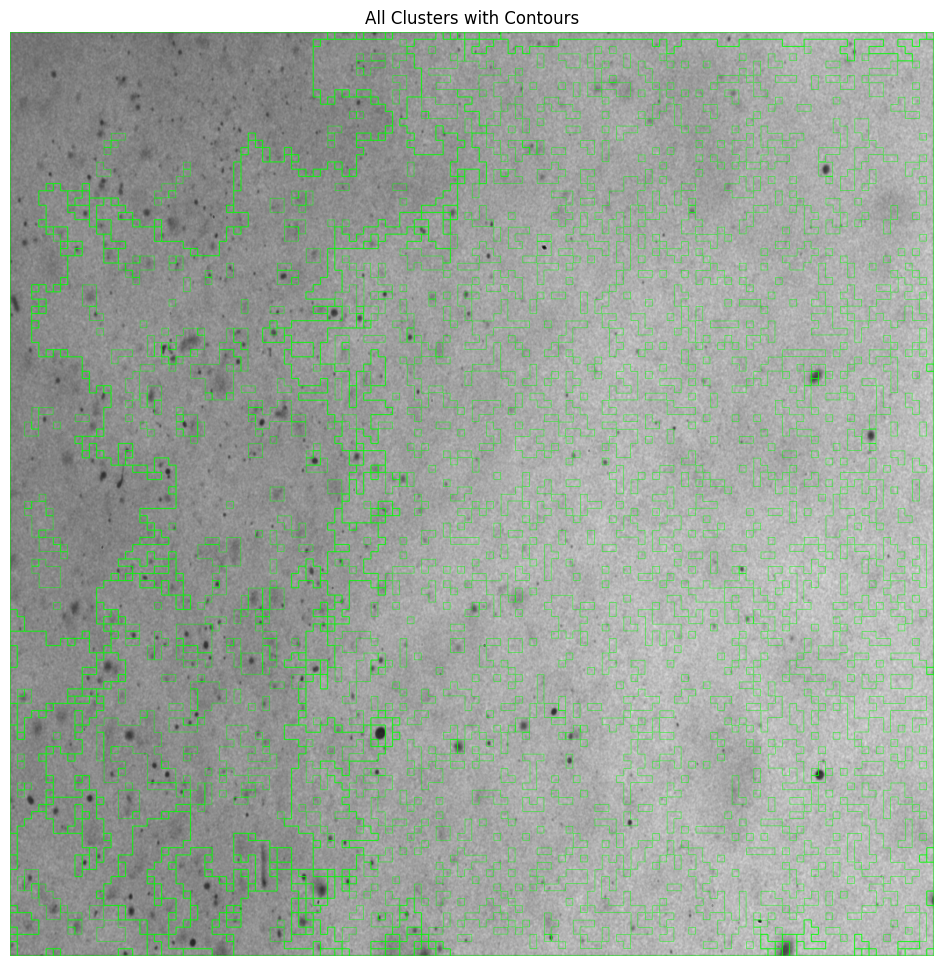

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


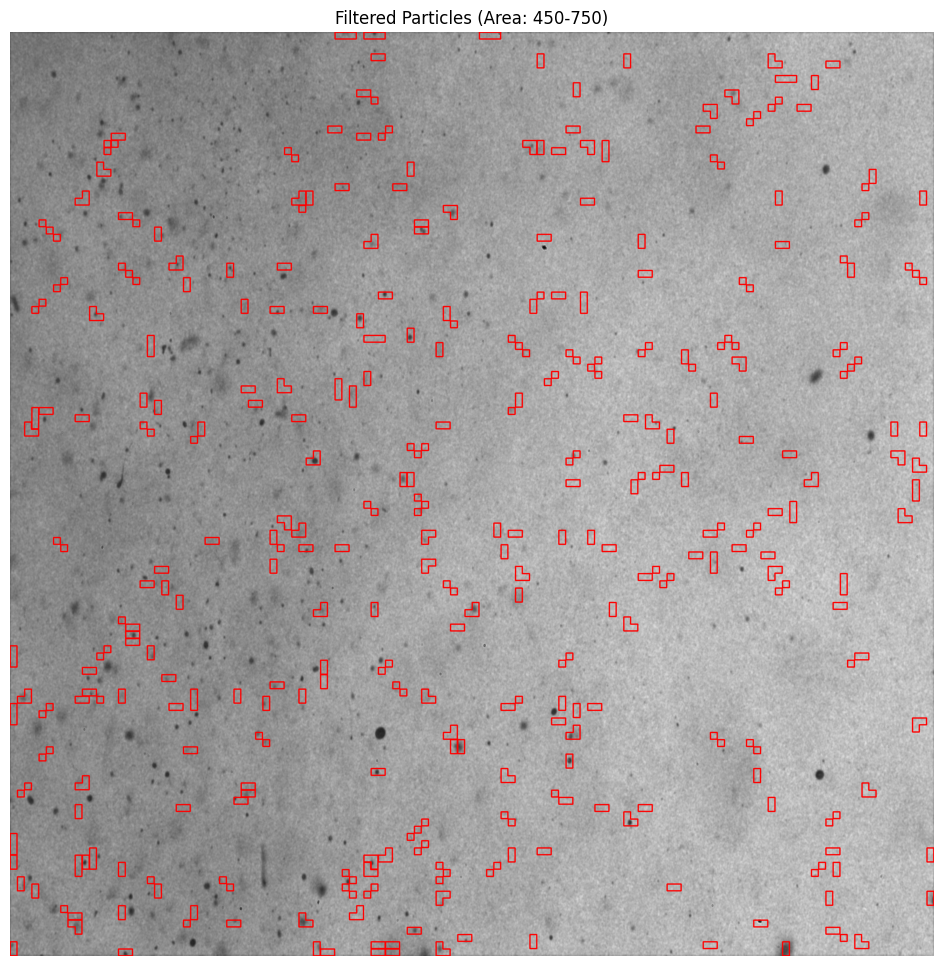

Total contours found: 997
Valid contours after filtering: 287


In [53]:
display_all_clusters_and_filter_by_size(
    sample_img=sample_img,
    cluster_labels_grid=cluster_labels_grid,
    min_area=450,    # Adjust to match expected particle size
    max_area=750,  # Adjust to match expected particle size
)

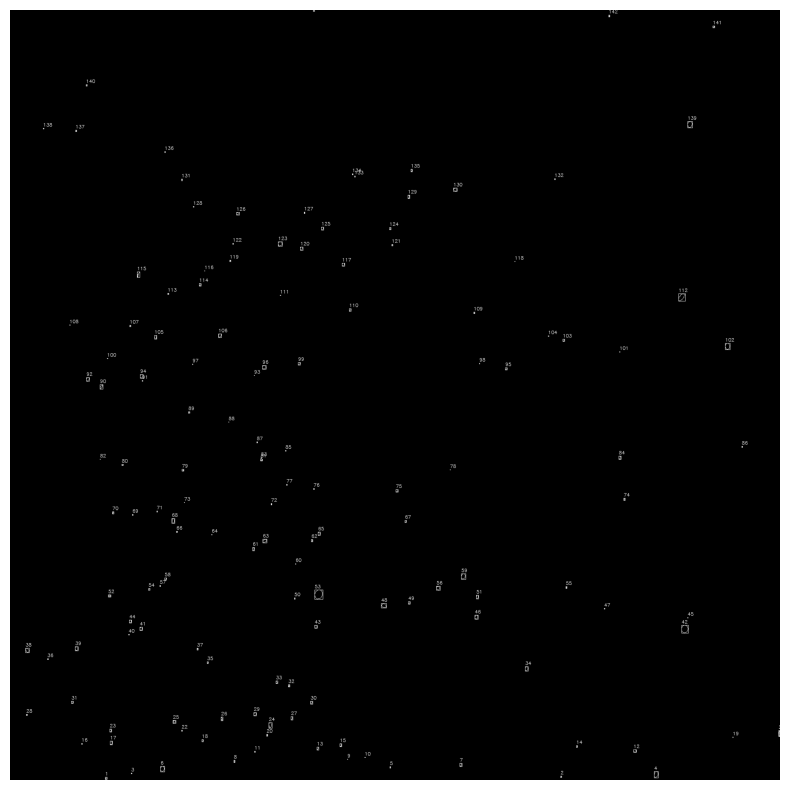

Sample_img
Number of particles: 143
Particle sizes: [12.5, 4.0, 0.5, 122.5, 2.5, 104.0, 33.0, 9.5, 0.0, 0.0, 1.0, 36.5, 18.0, 6.0, 23.0, 1.0, 41.0, 10.0, 0.0, 7.0, 25.5, 2.0, 22.0, 72.5, 31.0, 22.5, 26.5, 2.5, 36.5, 21.0, 17.0, 10.5, 15.5, 59.5, 7.0, 1.5, 5.5, 66.0, 58.5, 0.5, 38.5, 263.5, 36.0, 28.5, 0.0, 58.5, 0.5, 89.5, 21.0, 2.5, 34.5, 16.0, 375.0, 8.0, 6.0, 61.0, 1.5, 15.5, 111.5, 0.0, 22.5, 11.0, 55.5, 0.0, 32.5, 3.5, 11.5, 60.5, 1.0, 7.5, 1.5, 2.0, 0.0, 7.5, 20.5, 2.0, 1.5, 0.0, 14.0, 5.0, 14.5, 0.0, 0.0, 33.0, 1.0, 2.0, 1.5, 0.0, 5.0, 35.0, 1.0, 50.0, 0.0, 49.0, 18.0, 66.5, 0.0, 0.0, 25.0, 0.0, 0.0, 146.0, 16.0, 0.5, 33.5, 46.0, 4.0, 0.0, 4.5, 16.0, 0.0, 179.0, 4.0, 17.0, 35.0, 0.0, 36.0, 0.0, 3.0, 33.5, 5.0, 1.5, 87.5, 11.0, 29.5, 29.0, 2.5, 0.5, 27.0, 51.0, 2.0, 1.5, 0.5, 1.5, 13.0, 1.5, 5.0, 1.0, 142.5, 3.0, 11.0, 6.5, 2.5]



In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

threshold = 0.275

binary_mask = (error_map_image > threshold).astype(np.uint8)

contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contour_image = np.zeros_like(error_map_image, dtype=np.uint8)

particle_count = 0
for i, contour in enumerate(contours):
    cv2.drawContours(contour_image, [contour], -1, (255), 1)  # Draw white contours

    # Optionally, draw bounding boxes
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(contour_image, (x, y), (x + w, y + h), (255), 1)

    # Label each particle with a number
    cv2.putText(contour_image, f"{i + 1}", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255), 1)

    particle_count += 1

# Plot the results
plt.figure(figsize=(10, 10))
plt.imshow(contour_image, cmap="gray")
plt.axis("off")
plt.show()

particle_sizes = []
for contour in contours:
    area = cv2.contourArea(contour)
    particle_sizes.append(area)

print(f"Sample_img")
print(f"Number of particles: {len(contours)}")
print(f"Particle sizes: {particle_sizes}\n")